# Homework 7: Trees, random forest (14.5 points)

<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Part 1: The basics of building a decision tree

let's start with a simple one...

### Task 1.1 (1 point)
Let's say that 10 objects hit the vertex of the decision tree, 8 of which have a class label $k_1$, and 2 have a class label $k_2$. Calculate the entropy (with the natural logarithm). Round the answer to two decimal places.

In [2]:
print(f"%.2f" % (-0.8 * np.log(0.8) - 0.2 * np.log(0.2)))

0.50


### Task 1.2 (1 point)
Let's additionally know that the vertex from the previous assignment is not a leaf, and it is possible to split it so that all objects of class $k_1$ fall into the left subtree, and class $k_2$ into the right subtree. Calculate the criterion of informativeness (in terms of the difference between the impurity of the received sample and the resulting partition) of such a vertex using the Gini index. Round the answer to two decimal places.

In [3]:
print(f"%.2f" % ((0.8 * 0.2 + 0.2 * 0.8) - (1 * 0 + 0 * 1))) # или все-таки нужно делать с учетом пропорциональности?

0.32


### Task 1.3 (0.5 points)
Let's assume that when building a tree, a leaf vertex was formed with 10 objects, the values of the target variable for which are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] ( the regression problem is being solved). What will be the predictions of the model for these objects?

In [4]:
# these objects will fall into this sheet, which means that the forecast for each of them will be a forecast from this sheet, that is, the arithmetic mean
print(np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]))

40.6


## Part 2: Decision trees

### Task 2.1 (2 points)
First of all, implement the `find_best_split` function, which should find the optimal split of a subset of the training sample. When solving the regression problem, use the subsample variance, and when solving the classification problem, use the Gini criterion. This feature can be tested on the `Boston` dataset from `sklearn`.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [52]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

When solving the task, keep in mind that the Gini criterion refers to such a function:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

where $R$ is the set of objects that hit the vertex, $R_{\ell}$ and $R_r$ are objects that fall into the left and right subtrees,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ are the shares of objects of class 1 and 0, respectively.

For categorical features, a naive partitioning algorithm is used: we are trying to find one value, the partitioning of which will most significantly increase the criterion of informativeness. In other words, we send objects with a specific attribute value to the left subtree, and the rest to the right subtree. Please note that this is far from the optimal way to account for categorical features. For example, it would be possible to create a separate subtree for each value of a categorical feature or use more complex approaches. You can read more about this in the notes. [lectures](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf ) on machine learning at PMI (section "Accounting for categorical features").

As implementation hints, you can use the code from the bonus part of the seminar on decision trees (download the solved version of the notebook).

In [111]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    if task == 'classification':
        ginis = []
        if feature_type == 'categorical':
            thresholds = np.unique(feature_vector)
        elif feature_type == 'real':
            thresholds = np.unique([(x+y)/2 for x, y in zip(sorted(feature_vector)[:-1], sorted(feature_vector)[1:])])
        for i in thresholds:
            if len(set(feature_vector)) == 1:
                R_l = [j for j in range(math.floor(len(feature_vector) / 2))]
                R_r = [j for j in range(math.ceil(len(feature_vector) / 2))]
            else:
                if feature_type == 'categorical':
                    R_l = [j for j in range(len(feature_vector)) if feature_vector[j] == i]
                    R_r = [j for j in range(len(feature_vector)) if feature_vector[j] != i]
                    if len(R_l) == 0 or len(R_r) == 0:
                        thresholds = np.delete(thresholds, np.where(thresholds == i))
                        continue
                elif feature_type == 'real':
                    R_l = [j for j in range(len(feature_vector)) if feature_vector[j] < i]
                    R_r = [j for  j in range(len(feature_vector)) if feature_vector[j] >= i]
                    if len(R_l) == 0 or len(R_r) == 0:
                        thresholds = np.delete(thresholds, np.where(thresholds == i))
                        continue
            target_0_R_l = [j for j in R_l if target_vector[j] == 0]
            target_1_R_l = [j for j in R_l if target_vector[j] == 1]
            target_0_R_r = [j for j in R_r if target_vector[j] == 0]
            target_1_R_r = [j for j in R_r if target_vector[j] == 1]
            H_R_l = 1 - (len(target_0_R_l) / (len(R_l))) ** 2 - (len(target_1_R_l) / (len(R_l))) ** 2
            H_R_r = 1 - (len(target_0_R_r) / (len(R_r))) ** 2 - (len(target_1_R_r) / (len(R_r))) ** 2
            gini = -len(R_l) / len(R_l + R_r) * H_R_l - len(R_r) / len(R_l + R_r) * H_R_r
            ginis.append(gini)
    elif task == 'regression':
        ginis = []
        if feature_type == 'categorical':
             thresholds = np.unique(feature_vector)
        elif feature_type == 'real':
            thresholds = np.unique([(x+y)/2 for x, y in zip(sorted(feature_vector)[:-1], sorted(feature_vector)[1:])])
        for i in thresholds:
            if len(set(feature_vector)) == 1:
                R_l = [j for j in range(math.floor(len(feature_vector) / 2))]
                R_r = [j for j in range(math.ceil(len(feature_vector) / 2))]
            elif feature_type == 'categorical':
                    R_l = [j for j in range(len(feature_vector)) if feature_vector[j] == i]
                    R_r = [j for j in range(len(feature_vector)) if feature_vector[j] != i]
                    if len(R_l) == 0 or len(R_r) == 0:
                        thresholds = np.delete(thresholds, np.where(thresholds == i))
                        continue
            elif feature_type == 'real':
                R_l = [j for j in range(len(feature_vector)) if feature_vector[j] < i]
                R_r = [j for  j in range(len(feature_vector)) if feature_vector[j] >= i]
                if len(R_l) == 0 or len(R_r) == 0:
                    thresholds = np.delete(thresholds, np.where(thresholds == i))
                    continue
            target_R_l = [target_vector[j] for j in R_l]
            target_R_r = [target_vector[j] for j in R_r]
            H_R_l = np.var(target_R_l)
            H_R_r = np.var(target_R_r)
            gini = -len(R_l) / len(R_l + R_r) * H_R_l - len(R_r) / len(R_l + R_r) * H_R_r
            ginis.append(gini)
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = max(ginis)
    return thresholds, ginis, threshold_best, gini_best
            

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

In [112]:
threshold_best, variance_best

(6.68632, -68.08324641384722)

Plot the dependence of the value of the error criterion on the threshold value when dividing the vertex by the attribute `CRIM`.

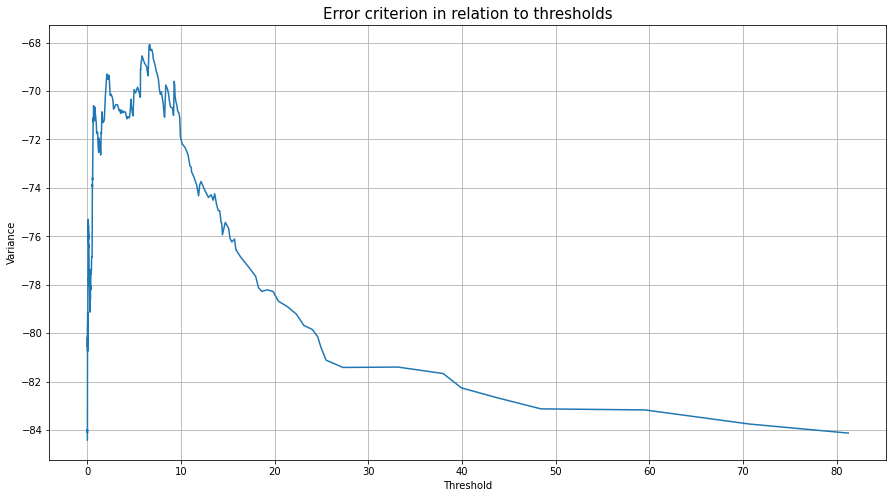

In [113]:
plt.figure(figsize=(15, 8))
plt.plot(thresholds, variances)
plt.title('Error criterion in relation to thresholds', fontsize=15)
plt.xlabel('Threshold', fontsize=10)
plt.ylabel('Variance', fontsize=10)
plt.grid()
plt.show()

### Task 2.2 (3 points)
Understand the written decision tree code, fill in the gaps in the code, and implement the missing _predict_node method.

The tree is built according to the basic greedy algorithm proposed in the lecture in the section "Building a tree".
- The choice of the best partition must be made according to the Gini criterion
- Stop criterion: all objects in the worksheet belong to the same class or the selection cannot be divided by any attribute.
- The answer is in the sheet: the most common class in the sheet

In [123]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == 'terminal':
            return node["class"]
        elif self._feature_types[node["feature_split"]] == "real" and x[node["feature_split"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
        elif self._feature_types[node["feature_split"]] == "real" and x[node["feature_split"]] > node["threshold"]:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[node["feature_split"]] == "categorical" and x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
        elif self._feature_types[node["feature_split"]] == "categorical" and x[node["feature_split"]] != node["category_split"]:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Assignment 2.3 (1 point)
Upload the table [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing ) (this is a slightly transformed dataset [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling )). In it, the attributes of the object are written in the first five columns, and in the last one the target variable (class: 0 or 1) is written. Plot five "threshold — value of the Gini criterion" curves on one image for all five features. Visualize the "feature value — class" scatter plots separately for all five features.

In [115]:
students = pd.read_csv('students.csv')
students

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


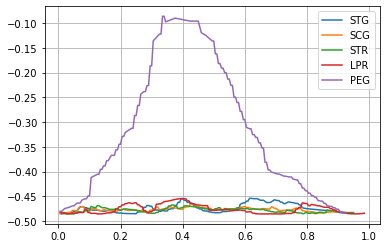

In [116]:
thresholds_STG, variances_STG, _, _ = find_best_split(students['STG'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
thresholds_SCG, variances_SCG, _, _ = find_best_split(students['SCG'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
thresholds_STR, variances_STR, _, _ = find_best_split(students['STR'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
thresholds_LPR, variances_LPR, _, _ = find_best_split(students['LPR'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
thresholds_PEG, variances_PEG, _, _ = find_best_split(students['PEG'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
plt.plot(thresholds_STG, variances_STG, label='STG')
plt.plot(thresholds_SCG, variances_SCG, label='SCG')
plt.plot(thresholds_STR, variances_STR, label='STR')
plt.plot(thresholds_LPR, variances_LPR, label='LPR')
plt.plot(thresholds_PEG, variances_PEG, label='PEG')
plt.legend()
plt.grid()
plt.show() 

In [117]:
thresholds_PEG, variances_PEG, threshold_bbest, _ = find_best_split(students['PEG'].to_numpy(), students[' UNS'], task='classification', feature_type='real')
threshold_bbest

0.335

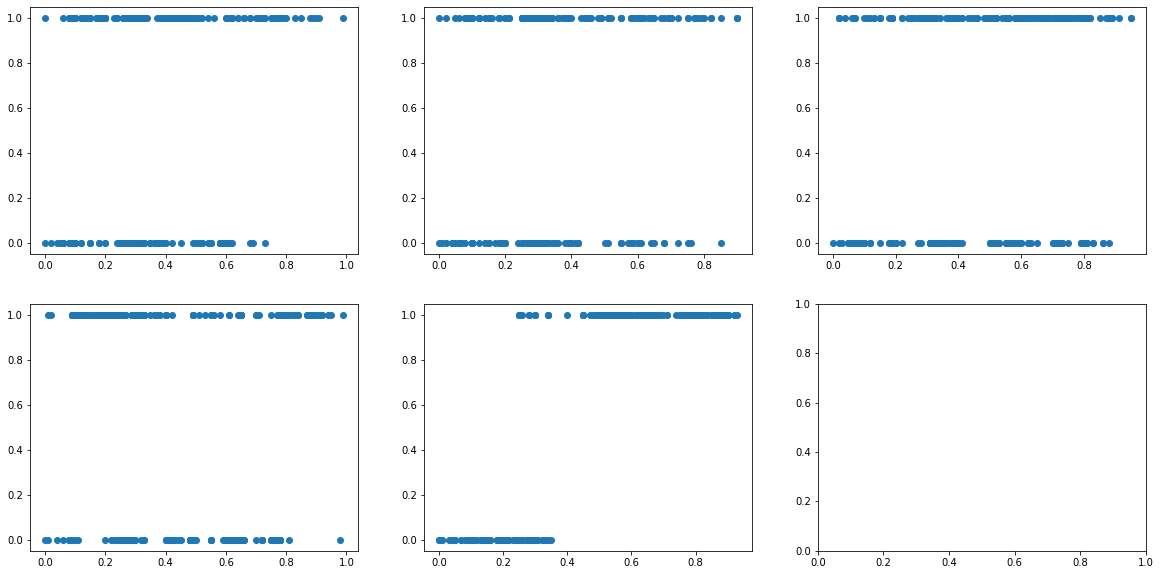

In [118]:
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0, 0].scatter(students['STG'], students[' UNS']);
ax[0, 1].scatter(students['SCG'], students[' UNS']);
ax[0, 2].scatter(students['STR'], students[' UNS']);
ax[1, 0].scatter(students['LPR'], students[' UNS']);
ax[1, 1].scatter(students['PEG'], students[' UNS']);

### Task 2.4 (1 point)

Based on the curves of the Gini criterion, on what basis should the sample be divided into two subtrees? Is this result consistent with the visual evaluation of scatter plots? How would you characterize the type of curve for "good" features, according to which the sample is divided almost perfectly? What is the difference between curves for features that are almost impossible to divide?

Based on the curves plotted above, the division should be based on the "PEG" attribute, since at a certain threshold (0.335) it is possible to achieve a minimum variance. This breakdown is quite consistent with the visual assessment, since it is clear that the classes can be most clearly divided, judging by the fifth graph, whereas in other graphs the classes are distributed more evenly. For "good" signs, the curve should have the shape closest to the arc, and the higher the top of the curve, the better.

### Task 2.5 (1 point)

Test your decision tree on the dataset [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom ). You need to download the agaricus-lepiota.data table (from [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/), read it using pandas, apply LabelEncoder (from sklearn) to each column to convert the string category names to natural numbers. The first column is the target variable (e — edible, p — poisonous) We will measure quality using accuracy, so it doesn't really matter to us what will be class 1 and what will be class 0. Train the decision tree on half of the randomly selected objects (the features in the dataset are categorical) and make predictions for the remaining half. Calculate accuracy.

In [119]:
data = pd.read_csv('agaricus-lepiota.data')
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [120]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for i in range(23):
    data.iloc[:, i] = labelencoder.fit_transform(data.iloc[:, i])
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [121]:
from sklearn.model_selection import train_test_split
X = data.drop('p', axis=1)
y = data['p']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=True, random_state=42)

In [125]:
from sklearn.metrics import accuracy_score
dtree = DecisionTree(['categorical'] * 22)
dtree_fitted = dtree.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = dtree_fitted.predict(X_test.to_numpy())
accuracy = accuracy_score(y_test, y_pred)
# Буду очень признателен, если расскажете, почему рекурсия не заканчивается, и исправите мой код, 
# чтобы я cмог посмотреть, как должно быть и понять свою ошибку

## Part 3: Bagging, random forest

In this part, we will work [with the task of predicting diabetes in a patient](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Let's look at the work of bagging on decision trees and random forest, compare their work.

In [85]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [166]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's look at the distribution of the target variable

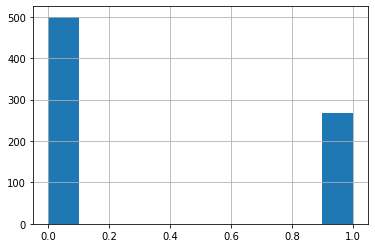

In [67]:
data['Outcome'].hist()
plt.show()

Divide the data into attributes and a target variable. Split the dataset into training and test parts with respect to 70:30.

In [167]:
X = data.drop('Outcome', 1)
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

### Task 3.1 (1 point)

Train [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) on 50 trees. Evaluate the classification quality in the test sample using the metrics `accuracy`, `precision` and `recall`, `auc_roc`.

In [168]:
bag = BaggingClassifier(n_estimators=50, random_state=47)
bag_fitted = bag.fit(X_train, y_train)
y_pred = bag_fitted.predict(X_test)
accuracy_bag = accuracy_score(y_test, y_pred)
precision_bag = precision_score(y_test, y_pred)
recall_bag = recall_score(y_test, y_pred)
roc_auc_bag = roc_auc_score(y_test, y_pred)

In [169]:
print(accuracy_bag)
print(precision_bag)
print(recall_bag)
print(roc_auc_bag)

0.7864583333333334
0.7884615384615384
0.5774647887323944
0.7432778489116517


### Task 3.2 (1 point)

Now train a Random Forest with the same number of trees. Evaluate the classification quality using the same metrics. Which of the two built models performed better?

In [170]:
forest = RandomForestClassifier(n_estimators=50, random_state=47)
forest_fitted = forest.fit(X_train, y_train)
y_pred = forest_fitted.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred)
precision_forest = precision_score(y_test, y_pred)
recall_forest = recall_score(y_test, y_pred)
roc_auc_forest = roc_auc_score(y_test, y_pred)

In [171]:
print(accuracy_forest)
print(precision_forest)
print(recall_forest)
print(roc_auc_forest)

0.7395833333333334
0.7142857142857143
0.49295774647887325
0.6886276335700151


Thus, the BaggingClassifier model turned out to be the best in all respects.

### Task 3.3 (1 point)

For a random forest, analyze the AUC-ROC value on the same data, depending on the parameter changes (you can do a routine iteration with training/testing in a loop):
* `n_estimators` (you can iterate through about 10 values from 10 to 1500)
* `min_samples_leaf` (you can choose the grid of values at your discretion)

Plot the corresponding graphs of AUC-ROC dependence on these parameters. Use the heat map for visualization. What conclusions can you draw?

In [87]:
hyperparams_forest = {'n_estimators': [1, 5, 10, 30, 70, 150, 300, 550, 100, 1500], 
                      'min_samples_leaf': [1, 3, 5, 10, 20]}
random_forest = GridSearchCV(forest_fitted, hyperparams_forest, verbose = 1)
random_forest_fitted = random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished


In [173]:
n_estimators = [1, 5, 10, 30, 70, 150, 300, 550, 100, 1500]
min_samples_leaf = [1, 3, 5, 10, 20]
values = random_forest_fitted.cv_results_['mean_test_score']
values_short = np.expand_dims([f"%.3f" % i for i in values], -1)
values_new = values_short.reshape(10, -1).astype(float)

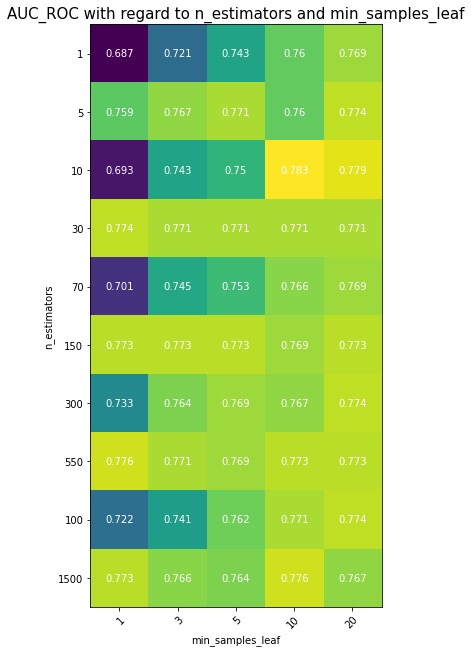

In [174]:
fig, ax = plt.subplots(figsize=(5,15))
im = ax.imshow(values_new)
ax.set_yticks(np.arange(len(n_estimators)))
ax.set_xticks(np.arange(len(min_samples_leaf)))
ax.set_yticklabels(n_estimators)
ax.set_xticklabels(min_samples_leaf)
ax.set_xlabel('min_samples_leaf', fontsize=10)
ax.set_ylabel('n_estimators', fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(n_estimators)):
    for j in range(len(min_samples_leaf)):
        text = ax.text(j, i, values_new[i, j],
                       ha="center", va="center", color="w")
ax.set_title("AUC_ROC with regard to n_estimators and min_samples_leaf", fontsize=15)
fig.tight_layout()
plt.show()

### Task 3.4 (1 point)

For a better random forest model, calculate the importance of features and build a barplot. What was the most important sign for determining diabetes?

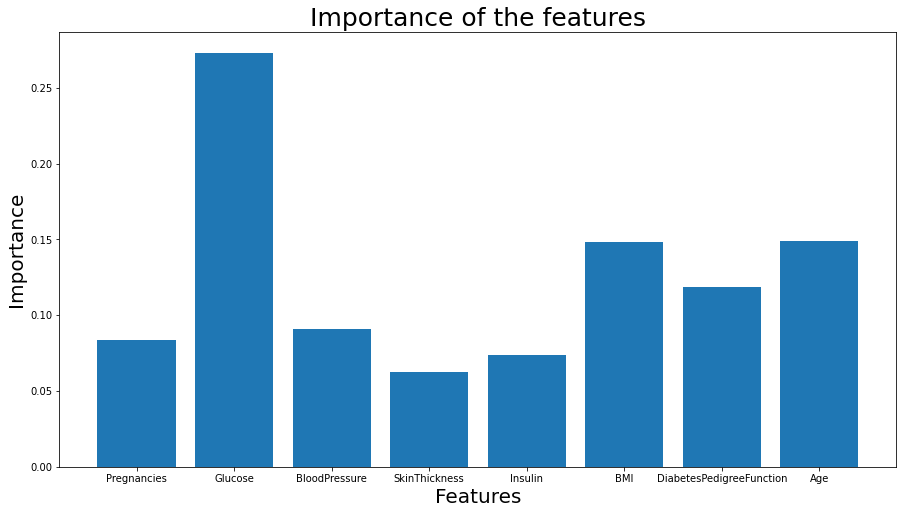

In [184]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.set_title('Importance of the features', fontsize=25)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.bar(X.columns, forest_fitted.feature_importances_)
plt.show()

The most important indicator was the concentration of glucose in the blood plasma.